**Title:** Customer Churn Prediction – Model Development, Validation, and Deployment

**Course Code:** 21AIC401T – Inferential Statistics and Predictive Analytics

**Students:** PREJAN RAJA S (RA2211047010019), SRI KRISHNA C (RA2211047010028)


In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn


**🔹Cell 1 : Importing Libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report
)
import pickle


**🔹Cell 2: Load Dataset**

In [4]:
from google.colab import files
uploaded = files.upload()  # Choose 'Telco-Customer-Churn.csv'
df = pd.read_csv(list(uploaded.keys())[0])
df.head()


Saving telco_customer_churn.csv to telco_customer_churn.csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**🔹Cell 3: Data Cleaning and Pre-Processing**

In [5]:
# Drop CustomerID if present
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values
df.dropna(inplace=True)

# Encode categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Target variable
df['Churn'] = df['Churn'].map({1:1, 0:0}) if df['Churn'].dtype != 'O' else df['Churn']

print(df.shape)
df.head()


(7032, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


**🔹 Cell 4 – Exploratory Data Analysis (EDA)**

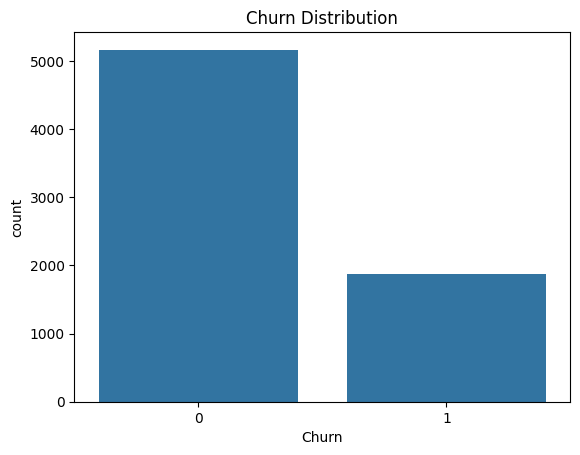

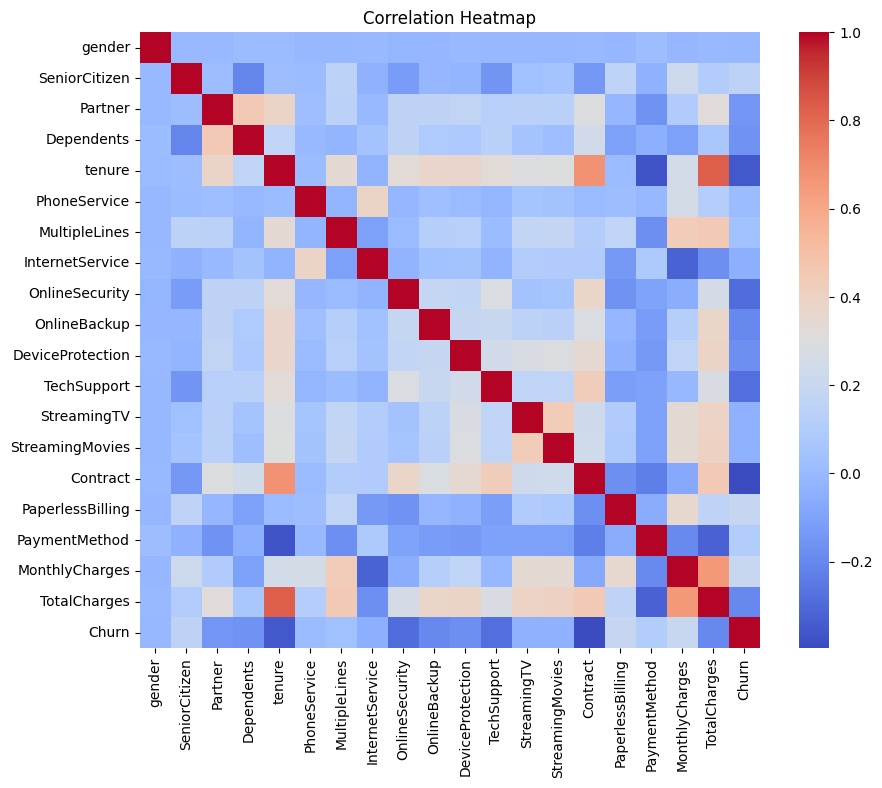

In [6]:
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


**🔹 Cell 5 – Split Data for Modeling**

In [7]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)


**🔹 Cell 6 – CHAID-like Decision Tree Model**

Decision Tree Rules:

|--- Contract <= 0.50
|   |--- OnlineSecurity <= 0.50
|   |   |--- tenure <= 10.50
|   |   |   |--- MonthlyCharges <= 75.78
|   |   |   |   |--- class: 1
|   |   |   |--- MonthlyCharges >  75.78
|   |   |   |   |--- class: 1
|   |   |--- tenure >  10.50
|   |   |   |--- InternetService <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- InternetService >  0.50
|   |   |   |   |--- class: 0
|   |--- OnlineSecurity >  0.50
|   |   |--- MonthlyCharges <= 91.72
|   |   |   |--- tenure <= 1.50
|   |   |   |   |--- class: 0
|   |   |   |--- tenure >  1.50
|   |   |   |   |--- class: 0
|   |   |--- MonthlyCharges >  91.72
|   |   |   |--- tenure <= 29.50
|   |   |   |   |--- class: 1
|   |   |   |--- tenure >  29.50
|   |   |   |   |--- class: 0
|--- Contract >  0.50
|   |--- MonthlyCharges <= 93.67
|   |   |--- Contract <= 1.50
|   |   |   |--- OnlineSecurity <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- OnlineSecurity >  0.50
|   |   |   |   |--- class: 0
|

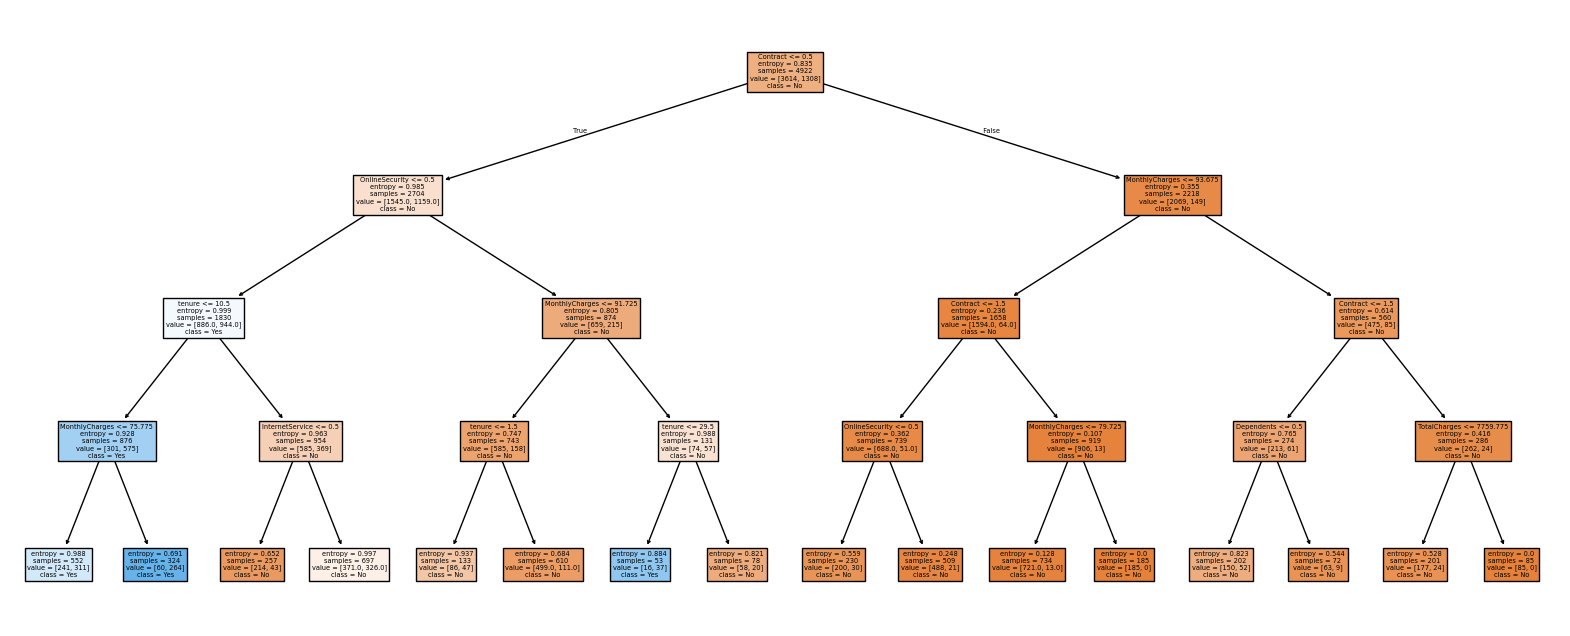

In [8]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=50, random_state=42)
dt.fit(X_train, y_train)

print("Decision Tree Rules:\n")
print(export_text(dt, feature_names=list(X.columns)))

plt.figure(figsize=(20,8))
plot_tree(dt, feature_names=X.columns, class_names=['No','Yes'], filled=True)
plt.show()


**🔹 Cell 7 – Logistic Regression Model**

In [9]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8004739336492891
ROC AUC: 0.8354645455811294
[[1373  176]
 [ 245  316]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1549
           1       0.64      0.56      0.60       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**🔹 Cell 8 – Model Comparison (ROC Curve + Lift)**

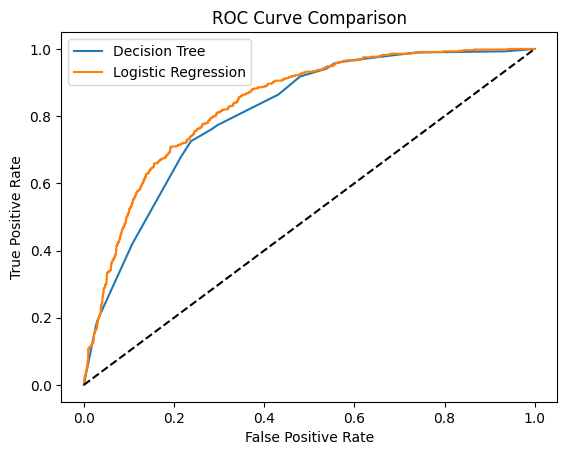

Lift by decile:
 bucket
0    0.962567
1    0.891266
2    1.105169
3    0.998217
4    1.176471
5    0.873440
6    0.891266
7    1.051693
8    0.926916
9    1.122995
Name: y_true, dtype: float64


In [10]:
# ROC Curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt.predict_proba(X_test)[:,1])
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr_dt, tpr_dt, label='Decision Tree')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Simple Lift by decile
temp = pd.DataFrame({'y_true':y_test, 'proba_lr':y_prob}).sort_values('proba_lr', ascending=False)
temp['bucket'] = pd.qcut(temp.index, 10, labels=False)
lift = temp.groupby('bucket')['y_true'].mean()/y_test.mean()
print("Lift by decile:\n", lift)


**🔹 Cell 9 – Save Models (for Deployment)**

In [11]:
with open('churn_model_logistic.pkl', 'wb') as f:
    pickle.dump(lr, f)
with open('churn_model_tree.pkl', 'wb') as f:
    pickle.dump(dt, f)

print("✅ Models saved in Colab working directory for download")


✅ Models saved in Colab working directory for download


**🔹 Cell 10 – Deployment and Updating Notes**

In [12]:
print("""
Deployment & Updating Strategy:
1. Export saved pickle models to Flask/FastAPI for real-time prediction.
2. Schedule monthly retraining using new data to avoid drift.
3. Track model performance via ROC AUC and retrain if performance drops > 5%.
""")



Deployment & Updating Strategy:
1. Export saved pickle models to Flask/FastAPI for real-time prediction.
2. Schedule monthly retraining using new data to avoid drift.
3. Track model performance via ROC AUC and retrain if performance drops > 5%.



In [13]:
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.2 MB/s eta 0:00:00


In [14]:
%%writefile app.py
import streamlit as st
import pickle
import numpy as np
import pandas as pd

# Load model
model = pickle.load(open('churn_model_logistic.pkl', 'rb'))

st.title("📞 Customer Churn Prediction App")
st.write("This app predicts whether a telecom customer is likely to churn.")

# Collect user inputs
gender = st.selectbox("Gender", ["Male", "Female"])
SeniorCitizen = st.selectbox("Senior Citizen", [0, 1])
tenure = st.number_input("Tenure (months)", 0, 72, 12)
MonthlyCharges = st.number_input("Monthly Charges", 0.0, 200.0, 70.0)
TotalCharges = st.number_input("Total Charges", 0.0, 10000.0, 2000.0)

# Convert to numeric array (simple 5 features demo)
input_data = np.array([[1 if gender=="Male" else 0, SeniorCitizen, tenure, MonthlyCharges, TotalCharges]])

if st.button("Predict Churn"):
    prediction = model.predict(input_data)[0]
    if prediction == 1:
        st.error("⚠️ This customer is **likely to churn!** Take retention actions.")
    else:
        st.success("✅ This customer is **not likely to churn.**")


Writing app.py


In [16]:
!npx localtunnel --port 8501


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇your url is: https://clean-dolls-own.loca.lt
/root/.npm/_npx/75ac80b86e83d4a2/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:12013 (check your firewall settings)
    at Socket.<anonymous> (/root/.npm/_npx/75ac80b86e83d4a2/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (node:events:524:28)
    at emitErrorNT (node:internal/streams/destroy:169:8)
    at emitErrorCloseNT (node:internal/streams/destroy:128:3)
    at process.processTicksAndRejections (node:internal/process/task_queues:82:21)

Node.js v20.19.0
⠙